Sentiment Analysis - Amazon Alexa Reviews

Analysing the Amazon Alexa dataset and build a classification model to predict whether the sentiment of a given input sentence is positive or negative

In [1]:
#import the dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to C:\Users\Pooja
[nltk_data]     Dhanush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/f5/b0/247159f61c5d5d6647171bef84430b7efad4db504f0229674024f3a4f7f2/wordcloud-1.9.3-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   --------------------- ------------------ 163.8/300.2 kB 4.8 MB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 4.6 MB/s eta 0:00:00




[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 259.2 kB/s eta 0:06:25
   ---------------------------------------- 0.0/99.8 MB 217.9 kB/s eta 0:07:38
   ---------------------------------------- 0.0/99.8 MB 217.9 kB/s eta 0:07:38
   ---------------------------------------- 0.0/99.8 MB 217.9 kB/s eta 0:07:38
   ---------------------------------------- 0.0/99.


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#Load the data

data = pd.read_csv(r"Data\amazon_alexa.tsv", delimiter = '\t', quoting = 3)

print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


In [3]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
print(f"Feature Names : {data.columns.values}")

Feature Names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [5]:
# checking the null values
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [6]:
data.dropna(inplace = True)

In [7]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [8]:
data.shape

(3149, 5)

In [9]:
# create a new column length that contain the length of the verified column
data['length']= data['verified_reviews'].apply(len)


In [10]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [11]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

Analysing the rating column

In [12]:
#Distinct values of 'rating' and its count  

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


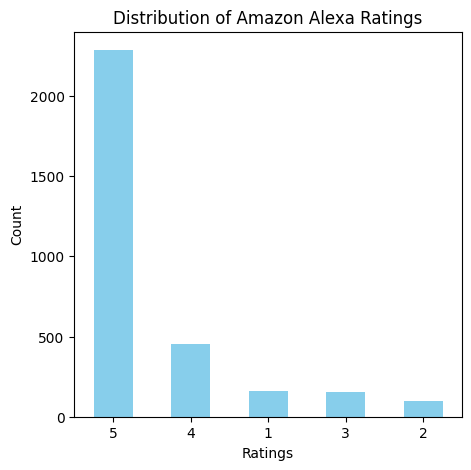

In [14]:
# bar plot to visualize the total count of each rating

plt.figure(figsize=(5,5))
data['rating'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Amazon Alexa Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [15]:
rating_count = data['rating'].value_counts()
rating_count

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

In [16]:
#find the percentage distribution of each rating

rating_percent = round((rating_count/rating_count.sum())*100,2)
print(f"Rating percentage distribution : \n{rating_percent}")

Rating percentage distribution : 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


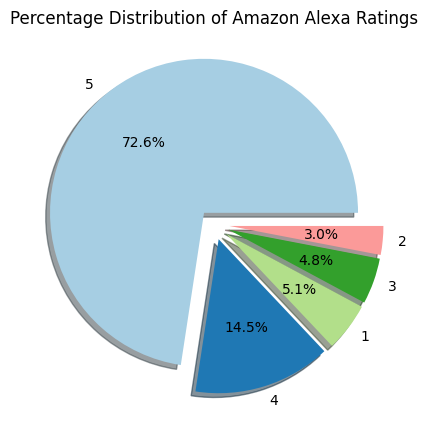

In [17]:
plt.figure(figsize=(5,5))
explode = (0.1,0.1,0.1,0.1,0.1)
plt.pie(rating_percent, labels=rating_percent.index, autopct='%1.1f%%',shadow = True,explode = explode, colors=plt.cm.Paired(range(len(rating_percent))))
plt.title('Percentage Distribution of Amazon Alexa Ratings')
plt.show()

Analysing the feedback column

In [18]:
 print(f"Feedback value count:\n{data.feedback.value_counts()}")

Feedback value count:
feedback
1    2893
0     256
Name: count, dtype: int64


There exists two distinct values for feedback. 

In [19]:
# Extracting what kind of review each value corresponds to.

feedback_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(feedback_0)

Sound is terrible if u want good music too get a bose


In [20]:
feedback_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(feedback_1)

Loved it!


From the above examples it is clear that the feedback 0 is for negative reviews and feedback 1 is for positive reviews

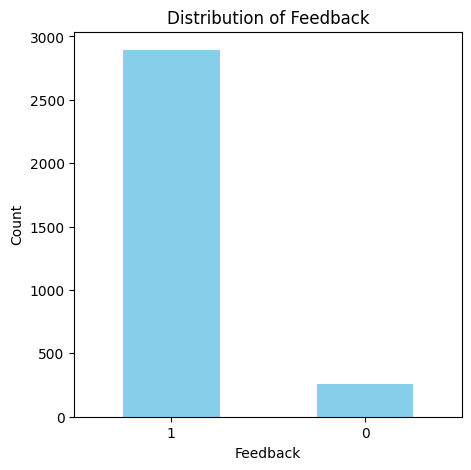

In [21]:
plt.figure(figsize=(5,5))
data['feedback'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Feedback')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [22]:
feedback_count = data['feedback'].value_counts()
feedback_percent = round((feedback_count/feedback_count.sum())*100,2)
print(f"Feedback percentage distribution : \n{feedback_percent}")

Feedback percentage distribution : 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


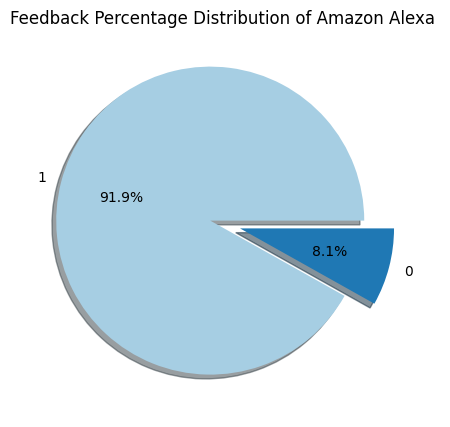

In [22]:
plt.figure(figsize=(5,5))
explode = (0.1,0.1)
plt.pie(feedback_percent, labels=feedback_percent.index, autopct='%1.1f%%',shadow = True,explode = explode, colors=plt.cm.Paired(range(len(feedback_percent))))
plt.title('Feedback Percentage Distribution of Amazon Alexa ')
plt.show()

Lets look the rating values of different values of feedback 

In [23]:
#feedback 0
data[data['feedback']==0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [24]:
#feedback 1
data[data['feedback']==1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

Rating 1 and 2 corresponds to review 0 and rating 5,4 and 3 to review 1

Analyse the variation column

In [25]:
#Distinct values of variation and its count
print(f"Variation value count : \n{data['variation'].value_counts()}")

Variation value count : 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


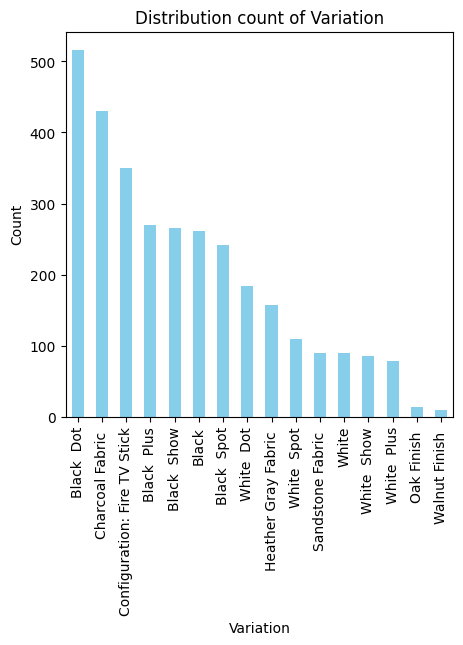

In [26]:
plt.figure(figsize=(5,5))
data['variation'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution count of Variation')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [27]:
variation_count = data['variation'].value_counts()
variation_percent = round((variation_count/variation_count.sum())*100,2)
print(f"Variation percentage distribution : \n{variation_percent}")

Variation percentage distribution : 
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


In [28]:
#mean rating according to variation

mean_rating = data.groupby('variation')['rating'].mean()
mean_rating

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

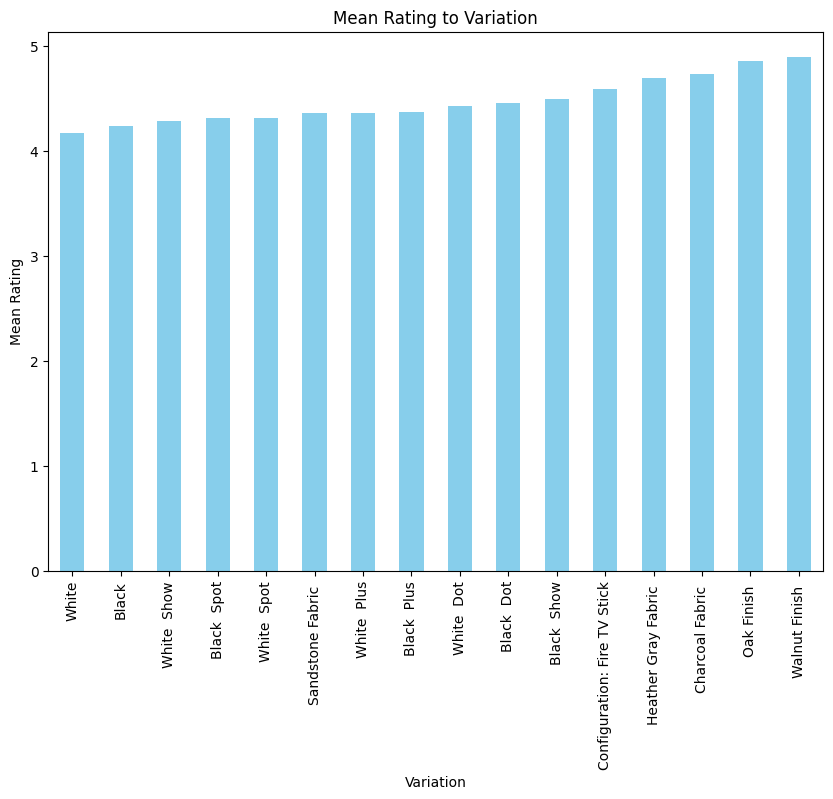

In [29]:
plt.figure(figsize=(10,7))
data.groupby('variation')['rating'].mean().sort_values().plot(kind='bar', color='skyblue')
plt.title('Mean Rating to Variation')
plt.xlabel('Variation')
plt.ylabel('Mean Rating')
plt.show()

Analysing the verified_reviews column

This column contains the textual reviews given by the user for different variants of the product

In [30]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

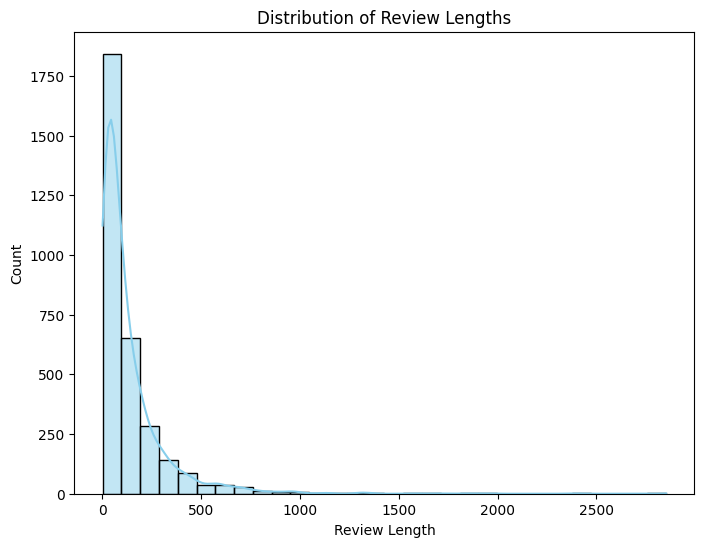

In [31]:
plt.figure(figsize=(8, 6))
sns.histplot(data['length'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Count')

plt.show()

[Text(0.5, 1.0, 'Distribution of length of reviews for feedback 0')]

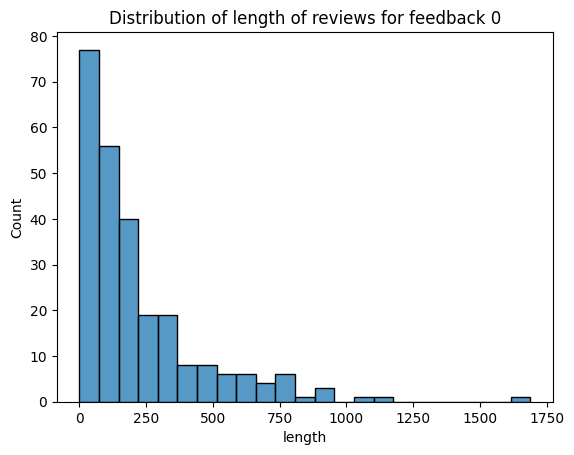

In [33]:
sns.histplot(data[data['feedback']==0]['length']).set(title = 'Distribution of length of reviews for feedback 0')

[Text(0.5, 1.0, 'Distribution of length of reviews for feedback 1')]

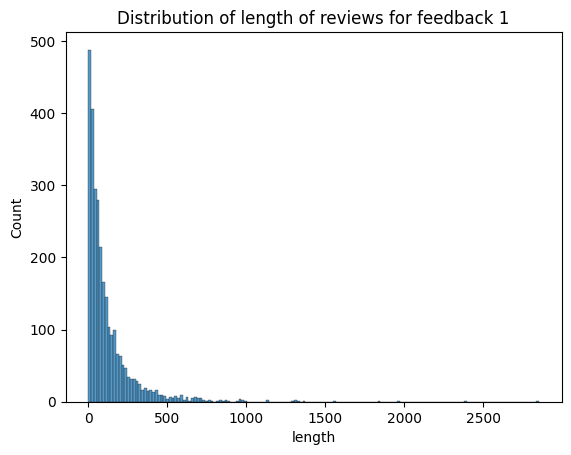

In [34]:
sns.histplot(data[data['feedback']==1]['length']).set(title = 'Distribution of length of reviews for feedback 1')

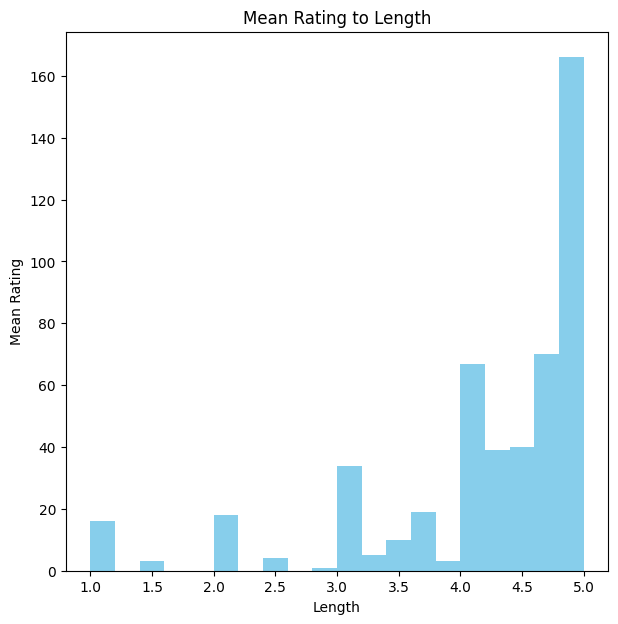

In [36]:
plt.figure(figsize=(7,7))
data.groupby('length')['rating'].mean().plot.hist(bins = 20, color='skyblue')
plt.title('Mean Rating to Length')
plt.xlabel('Length')
plt.ylabel('Mean Rating')
plt.show()

In [38]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(data['verified_reviews'])
reviews = " ".join(review for review in data['verified_reviews'] )

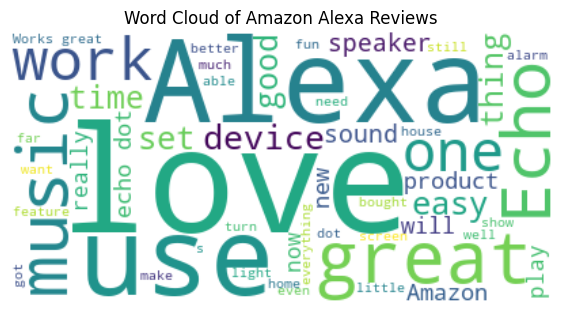

In [39]:
# initialize, generate and plot the word cloud

wc = WordCloud(background_color = 'white', max_words = 50)

wordcloud = wc.generate(reviews)
plt.figure(figsize=(7, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.title('Word Cloud of Amazon Alexa Reviews')
plt.show()

In [40]:
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


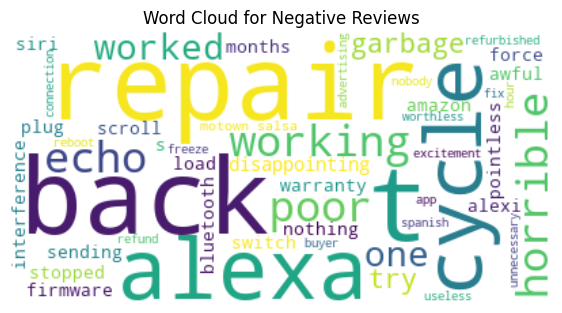

In [41]:
wc = WordCloud(background_color = 'white', max_words = 50)

wordcloud = wc.generate(unique_negative)
plt.figure(figsize=(7, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.title('Word Cloud for Negative Reviews')
plt.show()

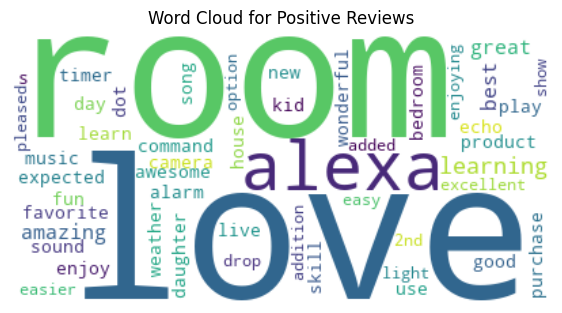

In [42]:
wc = WordCloud(background_color = 'white', max_words = 50)

wordcloud = wc.generate(unique_positive)
plt.figure(figsize=(7, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.title('Word Cloud for Positive Reviews')
plt.show()

Preprocessing and Model Building

In [43]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)


In [44]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [45]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [46]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


In [47]:
#Splitting data into train and test set with 30% data with testing.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


In [48]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


In [49]:
# scale X_train and X_test so that values ranges between 0 and 1

scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [50]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

In [51]:
# Random Forest Classifier

clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [52]:
print("Training Accuracy :", clf_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", clf_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9941016333938294
Testing Accuracy : 0.9439153439153439


In [53]:
y_preds = clf_rf.predict(X_test_scl)

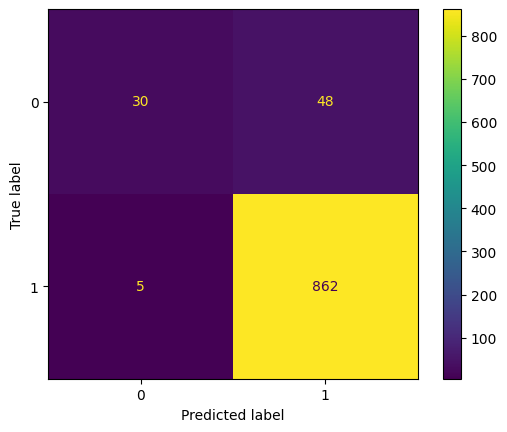

In [54]:
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf_rf.classes_)
cm_display.plot()
plt.show()

In [55]:
#Saving the RandomForest classifier
pickle.dump(clf_rf, open('Models/clf_rf.pkl', 'wb'))

kFold Cross Validation

In [56]:
accuracies = cross_val_score(estimator = clf_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.931489099136158
Standard Variance : 0.00771681785978644


 The above results indicate that the model is likely to generalize well to unseen data.

Applying GridSearch CV to get optimum parameters

In [57]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 50, 100],       # Maximum depth of the trees
    'min_samples_split': [8, 10, 12],   # Minimum number of samples required to split a node
    'min_samples_leaf': [2, 4, 6], # Minimum number of samples required at each leaf node
    'bootstrap': [True]
}

In [58]:
grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, scoring='accuracy', cv=5, return_train_score=True)
grid_search.fit(X_train_scl, y_train)
                           

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [None, 50, 100],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='accuracy')

In [59]:
#getting the best parametersfrom gridsearch

best_param = grid_search.best_params_
print("Best Parameters :", best_param)

Best Parameters : {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 100}


In [60]:
print(grid_search.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_bootstrap', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])


In [61]:
print("Cross-validation mean accuracy on train set: {:.2f}%".format(grid_search.cv_results_['mean_train_score'].mean() * 100))

print("Cross-validation mean accuracy on test set: {:.2f}%".format(grid_search.cv_results_['mean_test_score'].mean() * 100))

# Make predictions on the test set using the best model
y_preds = grid_search.best_estimator_.predict(X_test_scl)

print("Accuracy score for test set: {:.2f}%".format(accuracy_score(y_test, y_preds) * 100))


Cross-validation mean accuracy on train set: 92.40%
Cross-validation mean accuracy on test set: 91.95%
Accuracy score for test set: 91.64%


In [62]:
from sklearn.metrics import classification_report
print("Classification Report for RandomForest Classifier:")
print(classification_report(y_test, clf_rf.predict(X_test_scl)))

Classification Report for RandomForest Classifier:
              precision    recall  f1-score   support

           0       0.86      0.38      0.53        78
           1       0.95      0.99      0.97       867

    accuracy                           0.94       945
   macro avg       0.90      0.69      0.75       945
weighted avg       0.94      0.94      0.93       945



The small difference in the training and test accuracy suggests minimal overfitting and the model performs similarly well on both training and unseen data. We can fine tune the model or try different algorithms to see if it can give even better performance.

XgBoost

In [63]:
clf_xgb = XGBClassifier()
clf_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [64]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", clf_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", clf_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.971415607985481
Testing Accuracy : 0.9417989417989417


In [65]:
y_preds = clf_xgb.predict(X_test)

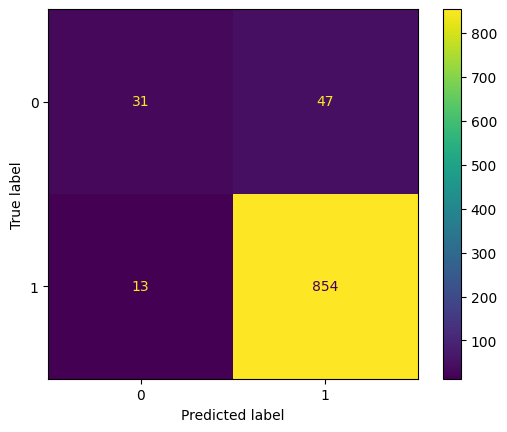

In [83]:
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf_xgb.classes_)
cm_display.plot()
plt.show()

In [66]:
#Saving the XGBoost classifier
pickle.dump(clf_xgb, open('Models/clf_xgb.pkl', 'wb'))

In [67]:
print("Classification Report for XGBClassifier:")
print(classification_report(y_test, clf_xgb.predict(X_test_scl)))

Classification Report for XGBClassifier:
              precision    recall  f1-score   support

           0       0.81      0.38      0.52        78
           1       0.95      0.99      0.97       867

    accuracy                           0.94       945
   macro avg       0.88      0.69      0.75       945
weighted avg       0.94      0.94      0.93       945



Decision Tree Classifier

In [68]:
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [69]:
 
print("Training Accuracy :", clf_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", clf_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9945553539019963
Testing Accuracy : 0.9174603174603174


In [70]:
y_preds = clf_dt.predict(X_test)

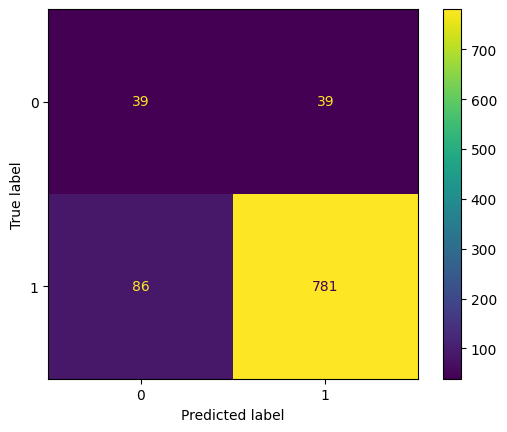

In [71]:
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf_dt.classes_)
cm_display.plot()
plt.show()

In [72]:
print("Classification Report for XGBClassifier:")
print(classification_report(y_test, clf_dt.predict(X_test_scl)))

Classification Report for XGBClassifier:
              precision    recall  f1-score   support

           0       0.50      0.58      0.54        78
           1       0.96      0.95      0.95       867

    accuracy                           0.92       945
   macro avg       0.73      0.76      0.75       945
weighted avg       0.92      0.92      0.92       945



In [73]:
#Saving the Decision Tree classifier
pickle.dump(clf_dt, open('Models/clf_dt.pkl', 'wb'))